# Titanic - Machine Learning from Disaster
This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
torch.__version__

'2.8.0+cu126'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class TitanicDataset(Dataset):

    def __init__(self, csv_file, is_test):
        super().__init__()
        self.df = pd.read_csv(csv_file)
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        item = self.df.iloc[index][1:]

        if self.is_test:
            data = item.values
            return torch.tensor(data, dtype=torch.float32)
        
        else:
            data = item.drop('Survived').values
            label = item['Survived']
            return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [5]:
train_dataset = TitanicDataset('./../datasets/titanic-train.csv', False)
test_dataset = TitanicDataset('./../datasets/titanic-test.csv', True)

In [6]:
train_dataset.df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
test_dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [9]:
mean_age = train_dataset.df['Age'].mean()
mean_fare = train_dataset.df['Fare'].mean()
embarked_unknown = 'Unknown'

train_dataset.df.fillna({'Age': mean_age, 'Fare': mean_fare, 'Embarked': embarked_unknown}, inplace=True)
test_dataset.df.fillna({'Age': mean_age, 'Fare': mean_fare, 'Embarked': embarked_unknown}, inplace=True)

train_dataset.df.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)
test_dataset.df.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)

In [10]:
sex_encoder = LabelEncoder()
train_dataset.df['Sex'] = sex_encoder.fit_transform(train_dataset.df['Sex'])
test_dataset.df['Sex'] = sex_encoder.transform(test_dataset.df['Sex'])

embarked_encoder = LabelEncoder()
train_dataset.df['Embarked'] = embarked_encoder.fit_transform(train_dataset.df['Embarked'])
test_dataset.df['Embarked'] = embarked_encoder.transform(test_dataset.df['Embarked'])

train_dataset.df['Pclass'] = train_dataset.df['Pclass'] - 1
test_dataset.df['Pclass'] = test_dataset.df['Pclass'] - 1

In [11]:
float_feats = ['Age', 'SibSp', 'Parch', 'Fare']

scaler = StandardScaler()
train_dataset.df[float_feats] = scaler.fit_transform(train_dataset.df[float_feats])
test_dataset.df[float_feats] = scaler.transform(test_dataset.df[float_feats])

In [12]:
train_dataset[0]

(tensor([ 2.0000,  1.0000, -0.5925,  0.4328, -0.4737, -0.5024,  2.0000]),
 tensor(0))

In [13]:
test_dataset[0]

tensor([ 2.0000,  1.0000,  0.3694, -0.4745, -0.4737, -0.4908,  1.0000])

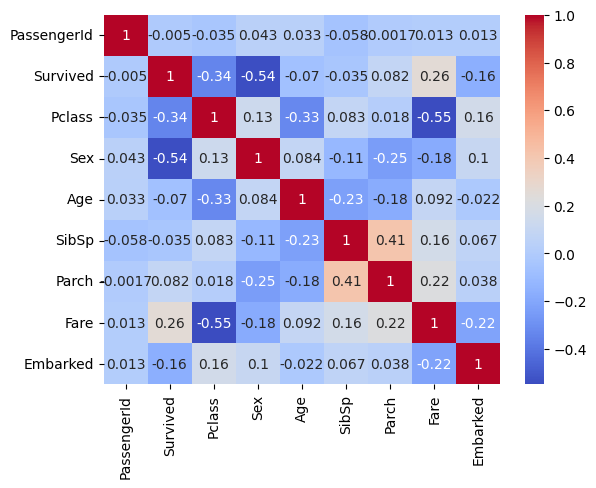

In [14]:
sns.heatmap(train_dataset.df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [15]:
class TitanicNN(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.in_layer = nn.Linear(7, 32)
        self.hid_layer = nn.Linear(32, 32)
        self.out_layer = nn.Linear(32, 2)
        self.relu = nn.ReLU()

        self.linear_layers = nn.Sequential(
            self.in_layer,
            self.relu,
            
            self.hid_layer,
            self.relu,

            self.out_layer
        )
    
    def forward(self, x):
        return self.linear_layers(x)

In [16]:
model = TitanicNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), 0.001)

In [17]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size, False)

In [18]:
num_epoch = 50

for epoch in range(num_epoch):
    n_correct = 0
    n_samples = 0

    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)
        n_correct += (labels == pred).sum().item()
        n_samples += len(data)

    print(f'Epoch {epoch+1} accuracy:', n_correct/n_samples)

Epoch 1 accuracy: 0.6071829405162739
Epoch 2 accuracy: 0.6161616161616161
Epoch 3 accuracy: 0.6408529741863075
Epoch 4 accuracy: 0.7115600448933782
Epoch 5 accuracy: 0.7362514029180696
Epoch 6 accuracy: 0.7508417508417509
Epoch 7 accuracy: 0.7710437710437711
Epoch 8 accuracy: 0.7822671156004489
Epoch 9 accuracy: 0.7968574635241302
Epoch 10 accuracy: 0.8024691358024691
Epoch 11 accuracy: 0.8069584736251403
Epoch 12 accuracy: 0.8226711560044894
Epoch 13 accuracy: 0.8181818181818182
Epoch 14 accuracy: 0.8215488215488216
Epoch 15 accuracy: 0.8237934904601572
Epoch 16 accuracy: 0.8226711560044894
Epoch 17 accuracy: 0.8271604938271605
Epoch 18 accuracy: 0.8282828282828283
Epoch 19 accuracy: 0.8271604938271605
Epoch 20 accuracy: 0.8237934904601572
Epoch 21 accuracy: 0.8305274971941639
Epoch 22 accuracy: 0.8271604938271605
Epoch 23 accuracy: 0.8294051627384961
Epoch 24 accuracy: 0.8294051627384961
Epoch 25 accuracy: 0.8338945005611672
Epoch 26 accuracy: 0.8294051627384961
Epoch 27 accuracy: 0.

In [19]:
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        outputs = model(data)

        _, pred = torch.max(outputs, 1)
        predictions.extend(pred.cpu().numpy())

predictions = np.array(predictions)
predictions

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [20]:
submission_df = pd.DataFrame({'PassengerId': test_dataset.df['PassengerId'].values, 'Survived': predictions})
submission_df.to_csv('./../submissions/titanic-submission.csv', index=False)